<a href="https://colab.research.google.com/github/yaoshiang/The-Real-World-Weight-Crossentropy-Loss-Function/blob/master/Real_World_Weighted_Crossentropy_Loss_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-World-Weighted Crossentropy Loss Function





This is a companion notebook to the paper published at <<<>>>.

Copyright (C) 2019 Yaoshiang Ho

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

Contact author for exceptions. 

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.

## Setup

In [0]:
# Import necessary libraries

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt

%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

from tensorflow import set_random_seed

import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import SGD

import scipy as sp

from tabulate import tabulate

import datetime

np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

1.15.0


Using TensorFlow backend.


In [0]:
# Fetch MNIST dataset

mnist = fetch_openml('mnist_784', cache=True)

In [0]:
#Processing on MNIST data
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X = X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## The Real-World-Weight Crossentropy loss functions for binary and categorical


In [0]:
# Copyright (C) 2019 Yaoshiang Ho

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Contact author for exceptions.
#
# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

def create_rww_binary_crossentropy(fn_weight, fp_weight):
  """
  binary_crossentropy is a special case of categorical_crossentropy.  
  The "all other" column is imputed. For single-label, an implementation is provided.
  However, this loss function is not very useful in a multi-label environment. 
  It only supports k=1. 
  
  In future work, we will provide an implementation for one target, 
  one miscategorization. Note that this will
  require a tensor of at lease size (k,k,2,2), where, the first 2 
  represents T/F of target, the second 2 represents the FP/FN of label. 

  We may also create a fully expressive loss function, which would require some
  efficient representation of a tensor of size (k, k, 2^k, 2^k)
  
  """  
  def binary_loss_function(target, output):
    output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
    logs = K.log(output) # shape (m, 1)
    logs_1_sub = K.log(1-output) # shape (m, 1)

    return - K.mean(target * fn_weight * logs + 
                    (1-target) * fp_weight * logs_1_sub)

  return binary_loss_function

def create_rww_categorical_crossentropy(k, loss_type, fn_weights=None, fp_weights=None, return_weights=False):
  """Real-World-Weighted crossentropy between an output tensor and a target tensor.
  
  The loss_types other than rww_categorical_crossentropy reimplement existing 
  functions in Keras but are not as well optimized. 
  These loss_types are usable directly, but, are more useful when calling 
  return_weights=True, which then returns fn and fp weights matrixes of size (k,k). 
  Editing those to reflect real world costs, then passing them back into 
  create_rww_crossentropy with loss_type "rww_crossentropy" is the recommended approach. 

  Example Usage: 

  Suppose you have three classes: cat, dog, and other.
  
  Cat is one-hot encoded as [1,0,0], dog as [0,1,0], other as [0,0,1]
  
  The the following code increases the incremental penalty of 
  mislabeling a true target 0 (cat) with a false label 1 (dog) at a cost of 99, 
  versus the default of zero. Note that the existing fn_weights also has a 
  default cost of 1 for missing the true target of 1, for a total cost of 
  100 versus the default cost of 1. 
  
  fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
  fp_weights[0, 1] = 99
  loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)

... 
  
  The fn and fp weights are easy to reason about. 
  
  fn_weights is [x1, __, __]
                [__, x2, __]
                [__, __, x3]
 
  x1 represents the scale of the cost for a fn for cat, x2 for dog, and x3 for other.
  
  This is calculated as fn_weight * log(y_pred). 
  
  In the case of loss_type=categorical_crossentropy, 
  x1, x2, and x3 all equal the value one. 
  All elements not on the main axis must equal zero. 
  
  Note that fn_weights could have been represented as a vector, 
  not a matrix, however, we use a matrix to keep symmetry with 
  fp_weights, and, to prepare for 
  multi-label classification. 
    
  ...

  fp_weights is concerned with the costs of the fps from the other classes. 

  fp_weights of [__, x1, x2]
                [x3, __, x4]
                [x5, x6, __]
 
  x1 represents the cost of predicting 1 for dog, when it should be 0 for cat. 
  x2 represents predicting 2 for other, when the target is 0 for cat. 
  x3 represents predicing 0 for cat, when the target is 1 for dog.
  etc. 
  
  Args:
    * k: 2 or more for number of categories, including "other". 
    * loss_type: "categorical_crossentropy" to initialize to 
      standard softmax_crossentropy behavior, 
      or "weighted_categorical_crossentropy" for standard behavior, or, 
      or "rww_crossentropy" for full weight matrix of all possible fn/fp combinations. 
    * fn_weights: a numpy array of shape (k,k). The main diagonal can
      contain non-zero values; all other values must be zero. 
    * fp_weights: a numpy array of shape (k,k) to define specific combinations 
      of false positive. The main diag should be zeros. 
    * return_weights: If False (default), returns cost function. If True, 
      returns fn and fp weights as np.array. 
Returns:
    * retval: Loss function for use Keras.model.fit, or if return_weights
      arg is True, the fn_weights and fp_weights matrixes. 
  """

  full_fn_weights = None
  full_fp_weights = None

  anti_eye = np.ones((k,k)) - np.eye(k)
    
  if (loss_type=="categorical_crossentropy"):
    full_fn_weights = np.identity((k))
    full_fp_weights = np.zeros((k, k)) # Softmax crossentropy ignores fp.

  elif(loss_type=="weighted_categorical_crossentropy"):
    full_fn_weights = np.eye(k) * fn_weights
    full_fp_weights = np.zeros((k, k)) # softmax crossentropy ignores fp
    
  elif(loss_type=="rww_crossentropy"):
    assert not np.count_nonzero(fn_weights * anti_eye)
    assert not np.count_nonzero(fp_weights * np.eye(k))

    full_fn_weights = fn_weights
    # Novel piece: allow any combination of fp.
    full_fp_weights = fp_weights
    
  else:
    raise Exception("unknown loss_type: " + str(loss_type))
   
  fn_wt = K.constant(full_fn_weights) # (k,k), always sparse along main diag. 
  fp_wt = K.constant(full_fp_weights) # (k,k), always dense except main diag. 

  def loss_function(target, output):
    output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
    logs = K.log(output) # shape (m, k), dense. 1 is good. 
    logs_1_sub = K.log(1-output) # shape (m, k), dense. 0 is good. 

    m_full_fn_weights = K.dot(target, fn_wt) # (m,k) . (k, k)
    m_full_fp_weights = K.dot(target, fp_wt) # (m,k) . (k, k)

    return - K.mean(m_full_fn_weights * logs + 
                    m_full_fp_weights * logs_1_sub)
  
  if (return_weights):
    return full_fn_weights, full_fp_weights
  else:
    return loss_function

In [0]:
# Example of categorical_crossentropy. Class behavior. 
fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'categorical_crossentropy', return_weights=True)
print("softmax cross entropy weights. k=5 classes. Expected output: fn: ones, fp:zeros. ")
print (fn_weights)
print (fp_weights)

# Example of weighted single-label categorical crossentropy. 
fn_weights, fp_weights = create_rww_categorical_crossentropy(5, 'weighted_categorical_crossentropy', np.array([1,2,3,4,5]), return_weights=True)
print("weighted softmax crossentropy. k=5 classes. Expected output: fn: weights, fp: zeros. ")
print (fn_weights)
print (fp_weights)


# Example of full weighted multi-label categorical crossentropy
fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
fp_weights[5, 8] = 19
loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)
print("real world weighted cross entropy weights. k=10 classes. If target label if 5, heavily penalize a (false positive) 8. ")
print (fn_weights)
print (fp_weights)

print(loss)

softmax cross entropy weights. k=5 classes. Expected output: fn: ones, fp:zeros. 
[[1.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.00 0.00 0.00]
 [0.00 0.00 1.00 0.00 0.00]
 [0.00 0.00 0.00 1.00 0.00]
 [0.00 0.00 0.00 0.00 1.00]]
[[0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]]
weighted softmax crossentropy. k=5 classes. Expected output: fn: weights, fp: zeros. 
[[1.00 0.00 0.00 0.00 0.00]
 [0.00 2.00 0.00 0.00 0.00]
 [0.00 0.00 3.00 0.00 0.00]
 [0.00 0.00 0.00 4.00 0.00]
 [0.00 0.00 0.00 0.00 5.00]]
[[0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00]]
real world weighted cross entropy weights. k=10 classes. If target label if 5, heavily penalize a (false positive) 8. 
[[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00]
 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0

## Testing Against Imbalanced Single-Label Multiclass (softmax)

In [0]:
def create_categorical_model(loss):
  k_y = k_x = Input(shape=(784,))
  k_y = Dense(50, activation='relu')(k_y)
  k_y = Dense(20, activation='relu')(k_y)
  k_y = Dense(10, activation='softmax')(k_y)

  model = Model(inputs=k_x, outputs=k_y)
  model.compile(optimizer='adam', loss=loss, metrics=['categorical_accuracy'])
  return model

# model_a = create_model("categorical_crossentropy")
# set_random_seed(1)
# model_a.fit(x = X_train, y = to_categorical(y_train), epochs=10, batch_size=100, validation_split=0.1)
# print(model_a.evaluate(X_test, to_categorical(y_test)))

In [0]:
def average_predictions(z, y):
  # Inputs: 
  #   z: raw output of softmax for m classes
  #   y: target predictions
  # Outputs:
  #   average predictions matrix of size (z.shape[1],z.shape[1])
  #     axis 0 are the true categories
  #     axis 1 are the predicted categories
  #     each cell is the average of the predictions
  m, n = z.shape
  y_pred = np.argmax(z, axis=1)  
  
  averages = np.zeros((n, n))
  
  for i in range(0, n):
    mask = y == np.array(i)
    assert mask.shape == (m,)
    np.mean(z[mask], axis=0, out=averages[i])
    
  return averages

# print("Average predictions for model_a. Rows are y, columns are y_hat")
# print(average_predictions(model_a.predict(X_test), y_test))

In [0]:
def num_predictions(z, y):
  # Inputs: 
  #   z: raw output of softmax for m classes
  #   y: target predictions using argmax
  # Outputs:
  #   total predictions matrix of size (z.shape[1],z.shape[1])
  #     axis 0 are the true categories
  #     axis 1 are the predicted categories
  #     each cell is the sum of the predictions
  m, n = z.shape
  y_pred = np.argmax(z, axis=1)  
  
  sums = np.zeros((n, n))
  
  for i in range(0, n):
    mask = y == np.array(i)
    assert mask.shape == (m,)    
    np.sum(to_categorical(np.argmax(z[mask], axis=1), num_classes=10), axis=0, out=sums[i])
  return sums

# print("Total number of predictions for model_a. Rows are y, columns are y_hat")
# np.set_printoptions(formatter={'float': lambda x: "{0:6.0f}".format(x)})
# print(num_predictions(model_a.predict(X_test), y_test))
# np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [0]:
# Calculate Real World Cost
def clip_correct(preds):
  k = preds.shape[0]
  assert k == preds.shape[1]
  
  anti_eye = 1 - np.eye(k)
  return preds * anti_eye # k,k, with the main diagonal masked out to zeros

def categorical_real_world_cost(preds, fn_ws, fp_ws):
  k = preds.shape[0]
  assert k == preds.shape[1]
  
  false_preds = clip_correct(preds)
  fn_cost = np.sum(np.sum(false_preds, axis=-1) * np.sum(fn_ws, axis=-1)) 
  fp_cost = np.sum(false_preds * fp_ws)
 
  return (fn_cost + fp_cost) / np.sum(preds)

def vector_categorical_real_world_cost(m, preds, fn_ws, fp_ws):
  retval = np.zeros(m)
  for i in range(0,m):
    retval[i] = categorical_real_world_cost(preds[i], fn_ws[i], fp_ws[i])
  return retval

In [0]:
def generate_unequal_pair(i):
  np.random.seed(i)
  a = np.random.randint(0, 10)
  b = np.random.randint(0,10)
  while a == b:
    b = np.random.randint(0,10)
  return a, b

EPOCHS = 10 # We experimentally found no significant benefit after 10 epochs

# For testing purposes only. Comment the following line out in typical usage. 
# EPOCHS = 1

# Repeatability
np.random.seed(1)
set_random_seed(1)

# Quick compare 10 sample and 10 control networks
for i in range(0,10):
  print(datetime.datetime.now(), end = " ")
  # Generate random socially biased or expensive fn,fp pair, setup rww_crossentropy loss function. 
  on_label, offensive_fp = generate_unequal_pair(i)  
  fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
  fp_weights[on_label, offensive_fp] = 19
  loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)

  # Train control model
  model_control = create_categorical_model('binary_crossentropy') # K/TF builtin
  model_control.fit(x = X_train, y = to_categorical(y_train), epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)
  num_pred_control = num_predictions(model_control.predict(X_test), y_test)
  _, acc_control = model_control.evaluate(X_test, to_categorical(y_test))
  
  # Train experimental model with same epochs / batchsize as control model. 
  model_test = create_categorical_model(loss) # RWW version
  model_test.fit(x = X_train, y = to_categorical(y_train), epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)  
  num_pred_test = num_predictions(model_test.predict(X_test), y_test)
  _, acc_test = model_test.evaluate(X_test, to_categorical(y_test), verbose=0)

  print("For test (fn:fp):(" + str(on_label) + "," + \
        str(offensive_fp) + "): FPs from (control, experimental): (" + \
        str(num_pred_control[on_label, offensive_fp]) + "," +\
        str(num_pred_test[on_label, offensive_fp]) + \
        "); Accuracy from (control, experimental):" + \
        '{:0.4f}'.format(acc_control) + ",", '{:0.4f}'.format(acc_test) + ")")

2019-10-31 16:27:03.787544 WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








17500/17500 [==============================] - 1s 40us/step
For test (fn:fp):(5,0): FPs from (control, experimental): (0.0,0.0); Accuracy from (control, experimental):0.9640, 0.9621)
17500/17500 [==============================] - 1s 42us/step
For test (fn:fp):(5,8): FPs from (control, experimental): (9.0,3.0); Accuracy from (control, experimental):0.9643, 0.9531)
17500/17500 [==============================] - 1s 42us/step
For test (fn:fp):(8,6): FPs from (control, experimental): (7.0,3.0); Accuracy from (control, experimental):0.9659, 0.9619)
17500/17500 [==============================] - 1s 46us/step
For test (fn:fp):(8,9): FPs from (control, experimental): 

In [11]:
# Train 90 control and 90 experimental models. 

# Repeatability
np.random.seed(1)
set_random_seed(1)

accs = []
fps = []
preds = []
ws = []

for i in range(0,10):
  for j in range (0,10):
    if i == j: 
      continue

    print(str(i*10 + j) + ":" + str(datetime.datetime.now()))

    fn_weights, fp_weights = create_rww_categorical_crossentropy(10, "categorical_crossentropy", return_weights=True)
    fp_weights[i, j] = 19
    loss = create_rww_categorical_crossentropy(10, "rww_crossentropy", fn_weights, fp_weights)

    # Train control model
    model_control = create_categorical_model('binary_crossentropy') # K/TF builtin
    model_control.fit(x = X_train, y = to_categorical(y_train), epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)
    num_pred_control = num_predictions(model_control.predict(X_test, verbose=0), y_test)
    _, acc_control = model_control.evaluate(X_test, to_categorical(y_test), verbose=0)
 
    # Train experimental model with same epochs / batchsize as control model. 
    model_test = create_categorical_model(loss) # RWW version
    model_test.fit(x = X_train, y = to_categorical(y_train), epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)  
    num_pred_test = num_predictions(model_test.predict(X_test, verbose=0), y_test)
    _, acc_test = model_test.evaluate(X_test, to_categorical(y_test), verbose=0)

    accs.append((acc_control, acc_test))
    fps.append((num_pred_control[i, j], num_pred_test[i,j]))
    preds.append((num_pred_control, num_pred_test))
    ws.append((fn_weights, fp_weights))

1:2019-10-31 16:34:28.411562
2:2019-10-31 16:35:15.641499
3:2019-10-31 16:36:04.309588
4:2019-10-31 16:36:53.598391
5:2019-10-31 16:37:44.013906
6:2019-10-31 16:38:35.755103
7:2019-10-31 16:39:27.471340
8:2019-10-31 16:40:19.238765
9:2019-10-31 16:41:11.398103
10:2019-10-31 16:42:04.525346
12:2019-10-31 16:42:58.343883
13:2019-10-31 16:43:53.783053
14:2019-10-31 16:44:48.990590
15:2019-10-31 16:45:45.556917
16:2019-10-31 16:46:43.239585
17:2019-10-31 16:47:41.491949
18:2019-10-31 16:48:40.153569
19:2019-10-31 16:49:39.483769
20:2019-10-31 16:50:39.901936
21:2019-10-31 16:51:40.507242
23:2019-10-31 16:52:41.733563
24:2019-10-31 16:53:44.510562
25:2019-10-31 16:54:48.745278
26:2019-10-31 16:55:53.604814
27:2019-10-31 16:56:58.964646
28:2019-10-31 16:58:05.038147
29:2019-10-31 16:59:12.085974
30:2019-10-31 17:00:19.074705
31:2019-10-31 17:01:26.620020
32:2019-10-31 17:02:35.133278
34:2019-10-31 17:03:44.581933
35:2019-10-31 17:04:54.563020
36:2019-10-31 17:06:05.738871
37:2019-10-31 17:07

In [12]:
# Perform t-test on results (number of mislabels). 

fps = np.array(fps)
statistic, pvalue = sp.stats.ttest_rel(fps[:,0], fps[:,1])

print(np.mean(fps[:,0]))
print(np.mean(fps[:,1]))

print(statistic)
print(pvalue)

6.666666666666667
2.566666666666667
7.77728080765712
1.2412310150695e-11


In [13]:
# Perform t-test on errors

accs = np.array(accs)
statistic, pvalue = sp.stats.ttest_rel(1. - accs[:,0], 1. - accs[:,1])

print(np.mean(1. - accs[:,0]))
print(np.mean(1. - accs[:,1]))

print(statistic)
print(pvalue)

0.03553079364473858
0.03625015871971373
-2.608956344831146
0.010652384228849258


In [14]:
# Perform t-test on real world cost
    
fn_ws = np.array(ws)[:,0,:,:] # size (90, k, k)
fp_ws = np.array(ws)[:,1,:,:] # size (90, k, k)

preds_c = np.array(preds)[:,0,:,:] # size (90, k, k)
preds_t = np.array(preds)[:,1,:,:] # size (90, k, k)

costs_c = vector_categorical_real_world_cost(90, preds_c, fn_ws, fp_ws)
costs_t = vector_categorical_real_world_cost(90, preds_t, fn_ws, fp_ws)

assert costs_c.shape == (90,)
assert costs_t.shape == (90,)

print(np.mean(costs_c))
print(np.mean(costs_t))

statistic, pvalue = sp.stats.ttest_rel(costs_c, costs_t)
print(statistic)
print(pvalue)


0.042768888888888884
0.039036825396825396
5.983466153692239
4.487857950902815e-08


# Testing against imbalanced binary data



In [0]:
def create_imbalanced_mnist_data(X, y, target, num_minority, batch=0):
  new_X, new_y = [], []
  
  mask = y == target
  anti_mask = y != target

  # Grab the target X
  X_label = X[mask]  
      
  # Reduce the number of target x
  start = batch * num_minority
  end = start + num_minority
  X_label = X_label[start:end,:]
  
  new_X = np.concatenate([X_label, X[anti_mask]])
  new_y = np.concatenate([np.ones((num_minority)), np.zeros(X[anti_mask].shape[0])])
  
  return new_X, new_y

def create_binary_model(loss):
  k_y = k_x = Input(shape=(784,))
  k_y = Dense(10, activation='relu')(k_y)
  k_y = Dense(1, activation='sigmoid')(k_y)

  model = Model(inputs=k_x, outputs=k_y)
  model.compile(optimizer='adam', loss=loss, metrics=['binary_accuracy'])
  return model

def binary_real_world_cost(fn, fp, fn_cost, fp_cost):
  return fn*fn_cost + fp*fp_cost

def binary_stats(z, y, threshold, fn_cost, fp_cost):
  z = np.squeeze(z)

  y_pred = z > threshold
  p = np.count_nonzero(y)
  n = np.count_nonzero(1.-y)

  tp = np.count_nonzero(y_pred * y)
  fn = np.count_nonzero((1.-y_pred) * y)
  tn = np.count_nonzero((1.-y_pred) * (1.-y))
  fp = np.count_nonzero(y_pred * (1.-y))

  recall = np.float64(tp) / (tp + fn) 
  precision = np.float64(tp) / (tp + fp)
  f1 = np.float64(2 * recall * precision) / (recall + precision)
  rwc = (binary_real_world_cost (fn, fp, fn_cost, fp_cost)) / (p+n)
  rwb = (p * fn_cost) / (p+n) - rwc
  err = (fn + fp) / n
  
  
  # XXX: This really should return a dict instead of an 12 tuple. 
  return p, n, tp, fn, tn, fp, recall, precision, f1, rwc, rwb, err

# This is the algorithm to fine tune the threshold hyperparameter after training. 
def search_threshold(z, y):
  best_t = 0;
  best_f1 = 0

  data = []
  
  for i in np.linspace(0.01, .99, num=100):
    _, _, _, _, _, _, _, _, f1, _, _, _ = binary_stats(z, y, i, 0, 0)
    data.append((i, f1))
    if f1 > best_f1:
      best_f1 = f1
      best_t = i  
  return best_t, data

0:0:2019-10-31 18:36:52.181039
                P      N    TP    FN     TN    FP    Recall    Precision        F1    Real World Cost    Real World Benefit       Err
------------  ---  -----  ----  ----  -----  ----  --------  -----------  --------  -----------------  --------------------  --------
Control       165  15767   143    22  15750    17  0.866667     0.893750  0.880000           2.868441             17.844590  0.002474
Control_adj   165  15767   150    15  15743    24  0.909091     0.862069  0.884956           2.033643             18.679387  0.002474
Experimental  165  15767   156     9  15722    45  0.945455     0.776119  0.852459           1.412252             19.300778  0.003425
0:1:2019-10-31 18:38:34.587286
                P      N    TP    FN     TN    FP    Recall    Precision        F1    Real World Cost    Real World Benefit       Err
------------  ---  -----  ----  ----  -----  ----  --------  -----------  --------  -----------------  --------------------  --------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


                P      N    TP    FN     TN    FP    Recall    Precision        F1    Real World Cost    Real World Benefit       Err
------------  ---  -----  ----  ----  -----  ----  --------  -----------  --------  -----------------  --------------------  --------
Control       165  15767   134    31  15764     3  0.812121     0.978102  0.887417           3.910369             16.802661  0.002156
Control_adj   165  15767   151    14  15753    14  0.915152     0.915152  0.915152           1.845343             18.867688  0.001776
Experimental  165  15767   156     9  15644   123  0.945455     0.559140  0.702703           1.901833             18.811198  0.008372
0:3:2019-10-31 18:42:01.157101
                P      N    TP    FN     TN    FP    Recall    Precision        F1    Real World Cost    Real World Benefit       Err
------------  ---  -----  ----  ----  -----  ----  --------  -----------  --------  -----------------  --------------------  --------
Control       165  15767   138 

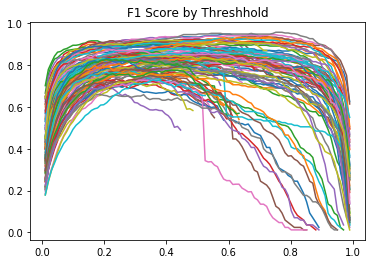

In [16]:
EPOCHS = 10 # We experimentally found no significant benefit after 10 epochs

# For testing purposes only. Comment the following line out in typical usage. 
# EPOCHS = 1

# Set some variables. 
FN_MARGINAL_COST = 2000 # E.g. if the disease is missed, it will get worse, costing an extra $2000 in future medical costs and pain and suffering
FP_MARGINAL_COST = 100 # E.g. marginal cost of FP is the cost of running a second, more expensive test to identify the TN. 

stats = np.zeros((100,3,12))

# Run it multiple times. 
for target in range (10):
  for batch in range (10):
    print(str(target) + ":" + str(batch) + ":" + str(datetime.datetime.now()))

    #Processing on MNIST data
    X = mnist.data.astype('float32')
    y = mnist.target.astype('int64')
    X /= 255.0

    # Generate data. Return value is not randomized. 
    X, y = create_imbalanced_mnist_data(X, y, target, 630, batch)
    # Shuffle and split into train and test data. 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

    # Build control and test models. 
    model_control = create_binary_model('binary_crossentropy')
    loss = create_rww_binary_crossentropy(FN_MARGINAL_COST, FP_MARGINAL_COST)
    model_test = create_binary_model(loss)

    model_control.fit(x = X_train, y = y_train, epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)      
    model_test.fit(x = X_train, y = y_train, epochs=EPOCHS, batch_size=100, validation_split=0.1, verbose=0)  

    y_pred_c = model_control.predict(X_test)
    y_pred_t = model_test.predict(X_test)

    stats_control = binary_stats(y_pred_c, y_test, 0.5, FN_MARGINAL_COST, FP_MARGINAL_COST)
    best_threshold, data = search_threshold(y_pred_c, y_test)
    stats_control_adj = binary_stats(y_pred_c, y_test, best_threshold, FN_MARGINAL_COST, FP_MARGINAL_COST)
    stats_test = binary_stats(y_pred_t, y_test, 0.5, FN_MARGINAL_COST, FP_MARGINAL_COST)

    print(tabulate([('Control',) + stats_control, \
                    ('Control_adj',) + stats_control_adj, \
                    ('Experimental',) + stats_test], \
                   headers=['P', 'N', 'TP', "FN", "TN", "FP", "Recall", \
                            "Precision", "F1", "Real World Cost", \
                            "Real World Benefit", "Err"], \
                   floatfmt=".6f"))

    plt.plot(np.array(data)[:,0], np.array(data)[:,1])
    plt.title('F1 Score by Threshhold')

    stats[target * 10 + batch, 0] = stats_control
    stats[target * 10 + batch, 1] = stats_control_adj
    stats[target * 10 + batch, 2] = stats_test

In [17]:
control1_test_p_values = np.zeros((12,1))
control2_test_p_values = np.zeros((12,1))

for i in range(stats.shape[2]):
  _, control1_test_p_values[i] = sp.stats.ttest_rel(stats[:, 0, i], stats[:, 2, i])
  _, control2_test_p_values[i] = sp.stats.ttest_rel(stats[:, 1, i], stats[:, 2, i])

print ("n=" + str(stats.shape[0]))
  
print(tabulate([('Control',) + tuple(np.mean(stats[:,0,:], axis=0)), \
                ('Control_adj',) + tuple(np.mean(stats[:,1,:], axis=0)), \
                ('Experimental',) + tuple(np.mean(stats[:,2,:], axis=0)), \
                ('control1_p_values',) + tuple(control1_test_p_values), \
                ('control2_p_values',) + tuple(control2_test_p_values) \
               ], \
               headers=['P', 'N', 'TP', "FN", "TN", "FP", "Recall", \
                        "Precision", "F1", "Real World Cost", \
                        "Real World Benefit", "Err"], \
               floatfmt=".20f"))

print(tabulate([('Control',) + tuple(np.mean(stats[:,0,:], axis=0)), \
                ('Control_adj',) + tuple(np.mean(stats[:,1,:], axis=0)), \
                ('Experimental',) + tuple(np.mean(stats[:,2,:], axis=0)), \
                ('control1_p_values',) + tuple(control1_test_p_values), \
                ('control2_p_values',) + tuple(control2_test_p_values) \
               ], \
               headers=['P', 'N', 'TP', "FN", "TN", "FP", "Recall", \
                        "Precision", "F1", "Real World Cost", \
                        "Real World Benefit", "Err"], \
               floatfmt=".20e"))


n=100
                                          P                           N                        TP                       FN                          TN                        FP                  Recall                 Precision                        F1         Real World Cost       Real World Benefit                     Err
-----------------  ------------------------  --------------------------  ------------------------  -----------------------  --------------------------  ------------------------  ----------------------  ------------------------  ------------------------  ----------------------  -----------------------  ----------------------
Control            164.69999999999998863132  15743.29999999999927240424  119.28000000000000113687  45.42000000000000170530  15730.64999999999963620212   12.65000000000000035527  0.72462614620498710938  nan                       nan                       5.78193359429067843536  14.92494230878920014050  0.00368466369279095169
Control_adj     


# Graphical Display of Loss Function Mechanics

(1000, 2)


Text(0, 0.5, 'Loss')

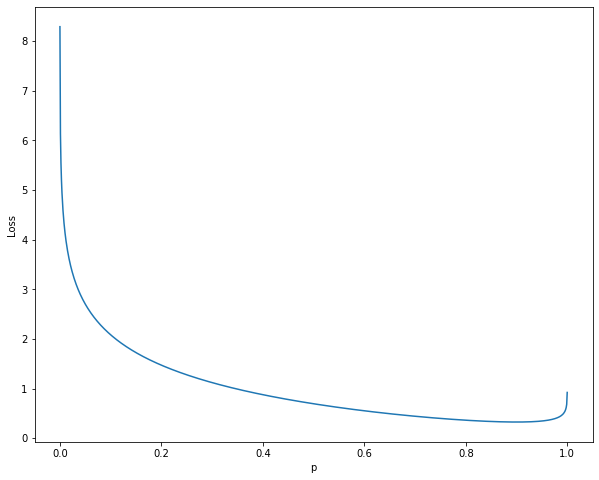

In [18]:
def J(z, y):
  if (y==1):
    return -np.log(z)
  elif (y==0):
    return -np.log(1-z)
  else:
    assert false

def J_batch(p, n_h, n_t):
  m = n_h + n_t
  x = np.zeros(m)

  for i in range(0,n_h):
    x[i] = 1

  retval = 0.
  for i in range(0, m):
    retval += J(p, x[i])
  retval /= x.shape[0]
  return retval

x_and_y = []
    
for i in np.linspace(0.0001, 0.9999, 1000):
  x_and_y.append((i, J_batch(i, 9, 1)))

x_and_y = np.array(x_and_y)

print(x_and_y.shape)
  
fig = plt.figure(figsize=(10,8))
plt.plot(x_and_y[:,0], x_and_y[:,1])
plt.xlabel('p')
plt.ylabel('Loss')


# Bernoulli Trial

A quick Bernoulli trial. Bias should be close to 2.1. Sigmoid(2.1) = 0.9, which is the minimum cost / accurate prediction for 9 heads and 1 tail. 

In [19]:
k_y = k_x = Input(shape=(1,))
k_y = Dense(1, activation='sigmoid', kernel_initializer='zeros',
                bias_initializer='ones')(k_y)

model_bernoulli = Model(inputs=k_x, outputs=k_y)
model_bernoulli.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

X = np.zeros((10,))
y = np.concatenate([np.ones((9,)), np.zeros((1,))])

model_bernoulli.fit(x = X, y = y, epochs=1000, verbose=0) 
print(model_bernoulli.evaluate(x = X, y = y))
print(model_bernoulli.get_weights()[1])

def sigmoid(x): return 1 / (1 + np.exp(-x))

print(sigmoid(model_bernoulli.get_weights()[1][0]))


10/10 [==============================] - 11s 1s/step
[0.33524543046951294, 0.8999999761581421]
[1.75]
0.8518968557974441
